In [2]:
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from remake import load_remake

from mcs_prime import PATHS

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
# Data pre-computed using SLURM. Taking ideas from Experimental below.

era5_hists = load_remake('../../remakefiles/era5_histograms.py')
ds = xr.open_dataset(era5_hists.CombineERA5Hist.tasks[0].outputs['hist'])
ds

<xarray.Dataset>
Dimensions:       (day: 366, hist_mid: 500, bins: 501)
Coordinates:
  * day           (day) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * hist_mid      (hist_mid) float64 5.0 15.0 25.0 ... 4.985e+03 4.995e+03
  * bins          (bins) float64 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03
Data variables:
    cape_full     (day, hist_mid) float64 ...
    cape_tropics  (day, hist_mid) float64 ...
    cape_eq       (day, hist_mid) float64 ...

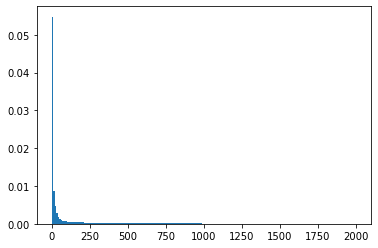

In [6]:
s = slice(0, 200, None)
h = ds.cape_full.values.sum(axis=0)[s]
bins = ds.bins.values
width = bins[1] - bins[0]
h_density = h / (h.sum() * width)
plt.bar(ds.hist_mid.values[s], h_density, width=bins[1] - bins[0]);

# Experimental

In [4]:
# e.g. /badc/ecmwf-era5/data/oper/an_sfc/2020/01/01/ecmwf-era5_oper_an_sfc_202001010300.cape.nc
e5datadir = PATHS['era5dir'] / 'data/oper/an_sfc'

# cape_files = sorted(e5datadir.glob('2020/**/*.cape.nc'))
year_cape_files = sorted(e5datadir.glob('2020/**/*.cape.nc'))

In [5]:
ds_out = xr.Dataset(
    coords=dict(
        day=np.arange(366),
        hist_mid=mids,
        bins=bins,
    ),
    data_vars=dict(
        cape_full=(('day', 'hist_mid'), cape_hists.copy()),
        cape_tropics=(('day', 'hist_mid'), cape_hists.copy()),
    )
)

NameError: name 'mids' is not defined

In [ ]:
bins = np.linspace(0, 5000, 501)
mids = (bins[1:] + bins[:-1]) / 2
cape_hists = np.zeros((len(year_cape_files) // 24, bins.size - 1))
print(bins.size)
for i in range(0, len(year_cape_files), 24):
    j = i // 24
    print(i, j)

    cape_files = year_cape_files[i:i + 24]
    da_cape = xr.open_mfdataset(cape_files).sel(latitude=slice(60, -60)).cape
    ds_out.cape_full[j] = np.histogram(da_cape.values, bins=bins)[0]
    ds_out.cape_tropics[j] = np.histogram(da_cape.sel(latitude=slice(20, -20)).values, bins=bins)[0]

In [ ]:
ds_out.cape_full.values[:5]

In [ ]:
h = ds_out.cape_full.values.sum(axis=0)
bins = ds_out.bins.values
plt.hist(ds_out.hist_mid.values, weights=h, bins=bins, density=True);

In [ ]:
cape = xr.open_mfdataset(cape_files).sel(latitude=slice(60, -60))
cape_values = cape.cape.values
cape_hist = np.histogram(cape_values, bins=np.linspace(200, 4000, 401))

In [ ]:
plt.hist(cape_values.flatten(), bins=np.linspace(0, 4000, 401), density=True, histtype='step');